In [27]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow_addons as tfa  # this is critical to load Addons>AdamW

In [28]:
# Helper function to inspect layer names in a model
def inspect_model_layers(model):
    """Prints all layer names in the model for identifying the last convolutional layer."""
    for idx, layer in enumerate(model.layers):
        print(f"Layer {idx}: {layer.name}, Type: {type(layer)}")

In [29]:
# GradCAM Function
def get_gradcam(model, img_array, last_conv_layer_name):
    """Generate GradCAM heatmap for a given model and input image."""
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), class_idx.numpy()

In [30]:
# Overlay heatmap on the original image
def overlay_heatmap(heatmap, img, alpha=0.4):
    """Overlay the GradCAM heatmap onto the original image."""
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay

In [31]:
# Paths to the trained model
base_path = "../"
model_path = f"EyeNet_Model.h5"
# model_path = f"EyeNet_Model.h5"

# Register AdamW optimizer
custom_objects = {
    'Addons>AdamW': tfa.optimizers.AdamW,
}

model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# Inspect layer names to find the last convolutional layer
print("Inspecting Multiclass Model layers:")
inspect_model_layers(model)

Inspecting Multiclass Model layers:
Layer 0: input_2, Type: <class 'keras.engine.input_layer.InputLayer'>
Layer 1: zero_padding2d_2, Type: <class 'keras.layers.reshaping.zero_padding2d.ZeroPadding2D'>
Layer 2: conv1/conv, Type: <class 'keras.layers.convolutional.conv2d.Conv2D'>
Layer 3: conv1/bn, Type: <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
Layer 4: conv1/relu, Type: <class 'keras.layers.core.activation.Activation'>
Layer 5: zero_padding2d_3, Type: <class 'keras.layers.reshaping.zero_padding2d.ZeroPadding2D'>
Layer 6: pool1, Type: <class 'keras.layers.pooling.max_pooling2d.MaxPooling2D'>
Layer 7: conv2_block1_0_bn, Type: <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
Layer 8: conv2_block1_0_relu, Type: <class 'keras.layers.core.activation.Activation'>
Layer 9: conv2_block1_1_conv, Type: <class 'keras.layers.convolutional.conv2d.Conv2D'>
Layer 10: conv2_block1_1_bn, Type: <class 'keras.layers.normalization.batch_normaliza

In [32]:
# Update the last convolutional layer name after inspection
last_conv_layer_name = "multiply_5"

# Preprocess eye image
def preprocess_eye_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, (224, 224)) / 255.0
    return np.expand_dims(img, axis=0)

# Analyze eye image
def analyze_eyes(eye_image_path, model):
    """
    Analyze the eye image using the trained model.
    Returns the predicted class and confidence percentages for all classes.
    """
    # Preprocess the image
    processed_image = preprocess_eye_image(eye_image_path)

    # Make prediction
    predictions = model.predict(processed_image)[0]
    classes = ["Cataract", "Conjunctivitis", "Healthy", "Stye"]
    confidences = {classes[i]: predictions[i] * 100 for i in range(len(classes))}
    predicted_class = classes[np.argmax(predictions)]
    return predicted_class, confidences

1/1 [==============================] - 0s 24ms/step


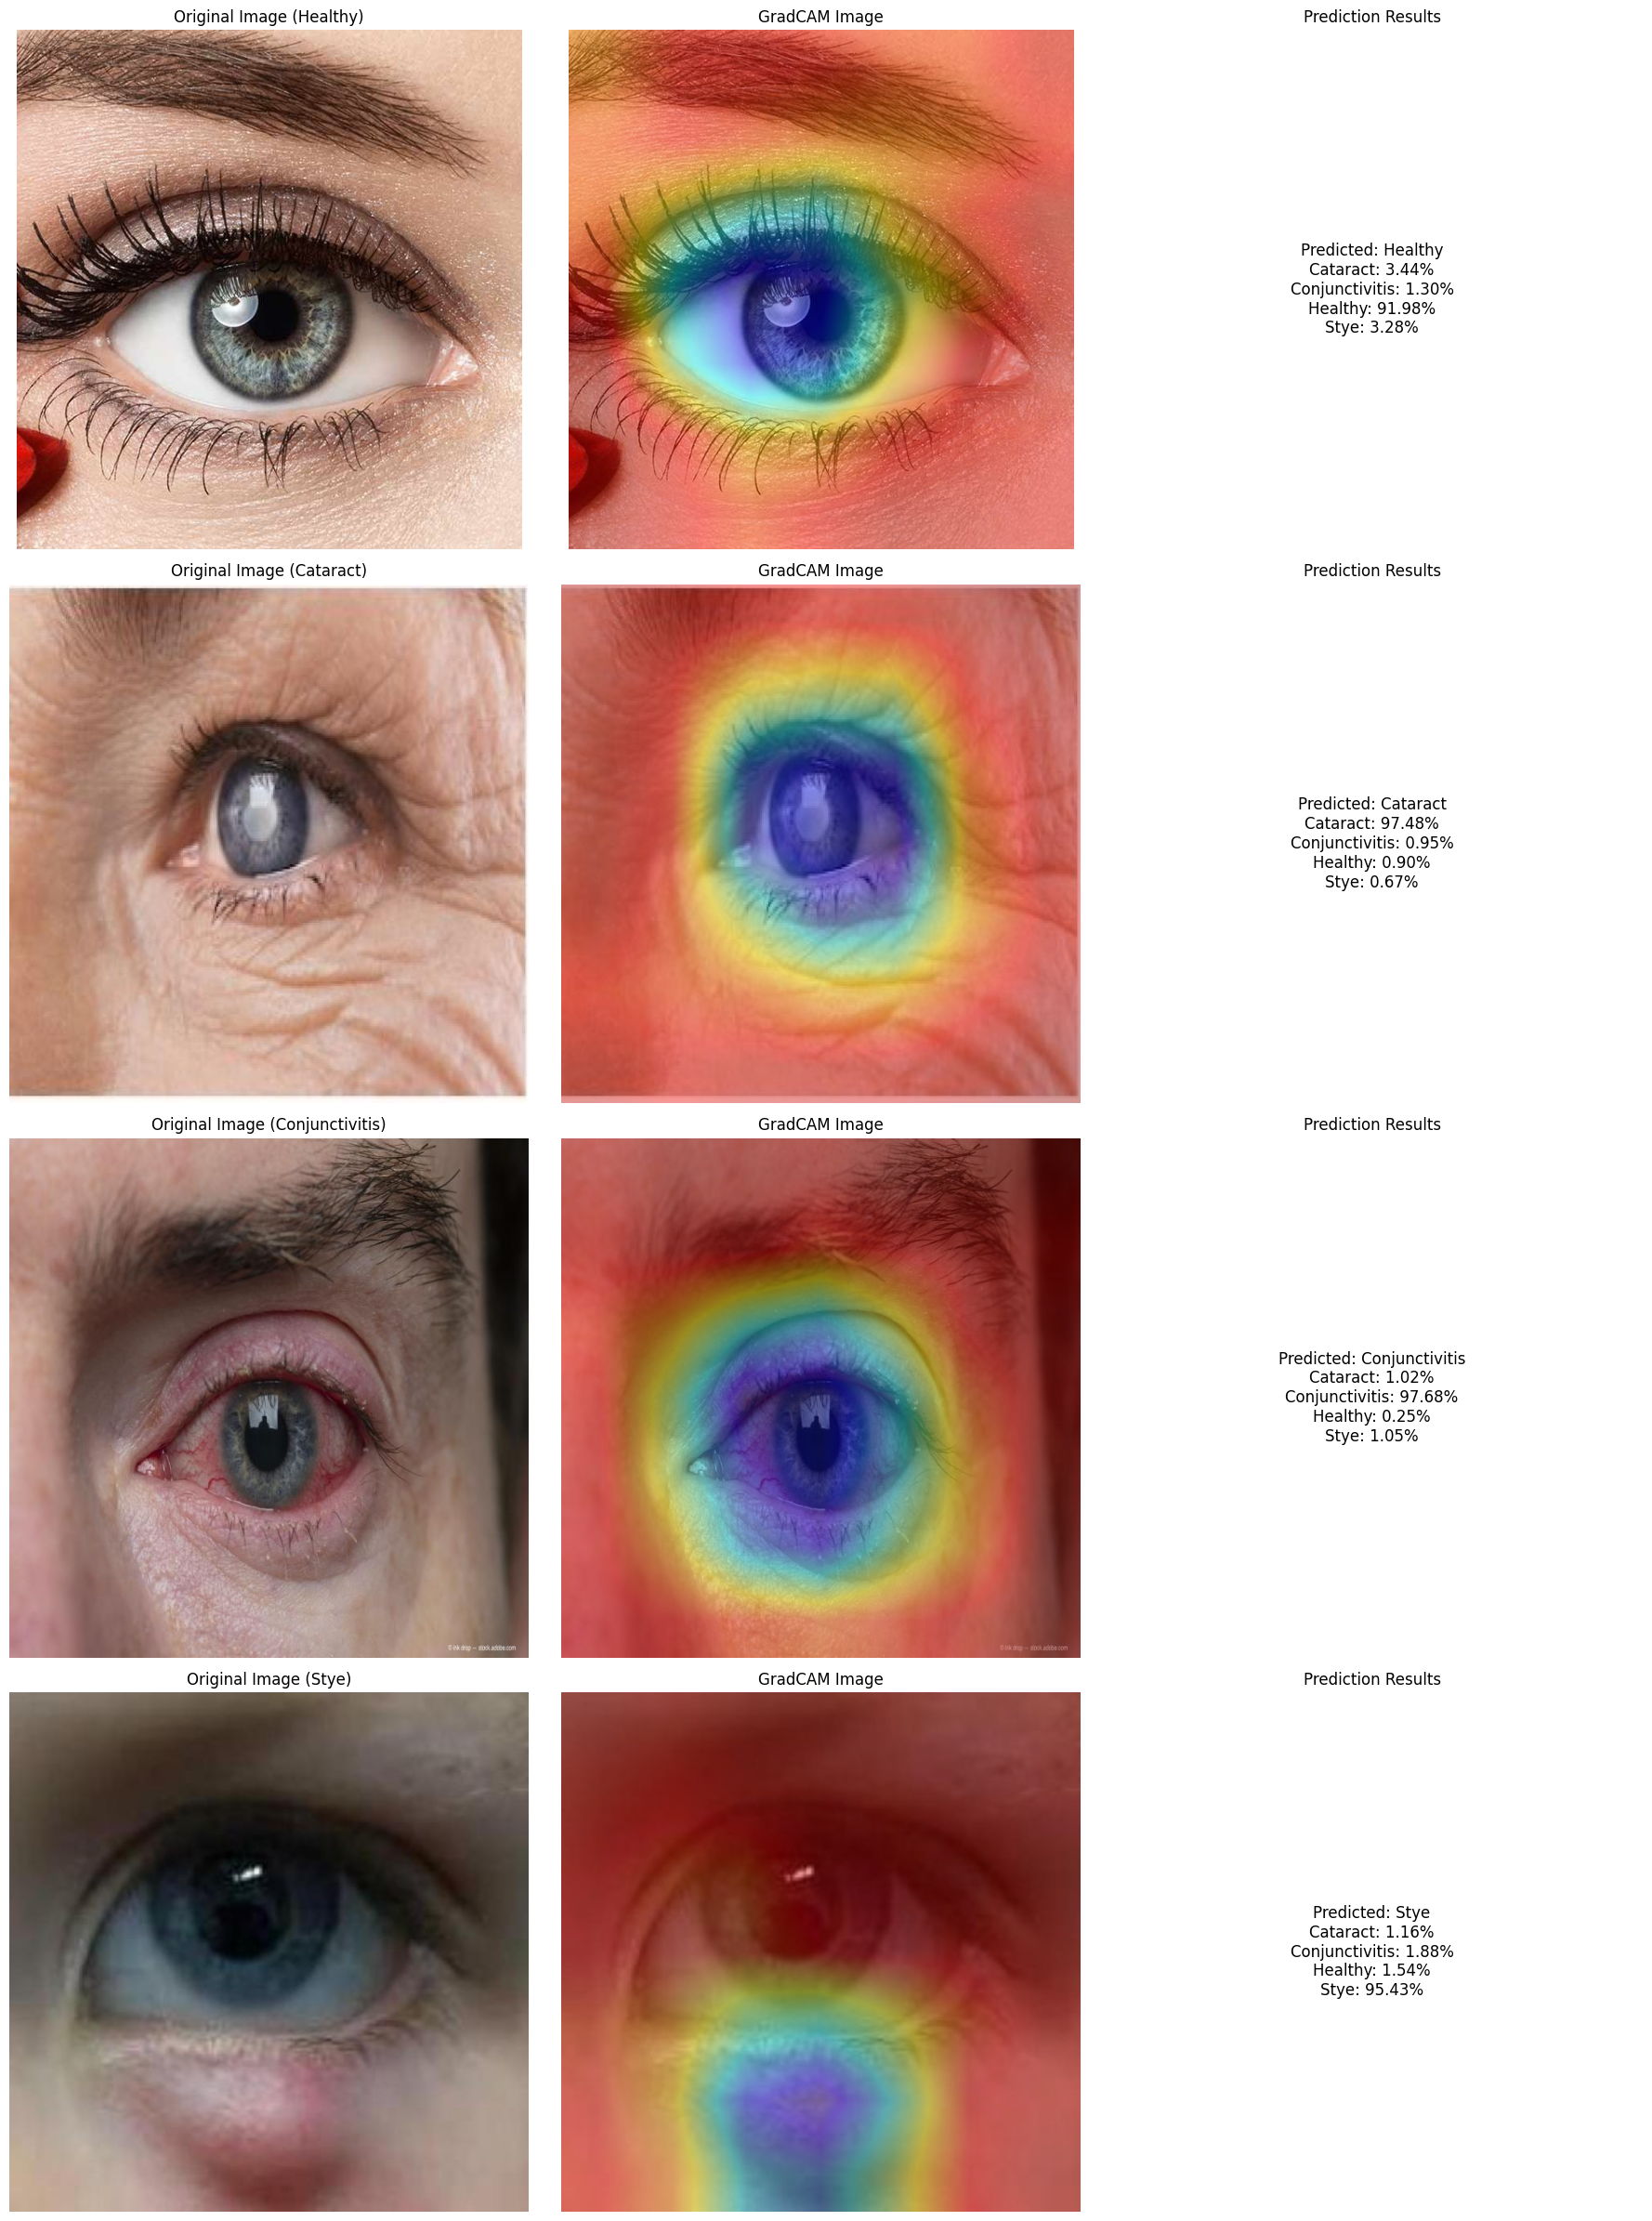

In [33]:
# Paths to input images
input_images = {
    "Healthy": "input_heal.jpg",
    "Cataract": "input_cat.jpg",
    "Conjunctivitis": "input_conj.jpg",
    "Stye": "input_st.jpg",
}

# Generate the comparison figure
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
classes = ["Healthy", "Cataract", "Conjunctivitis", "Stye"]

for i, cls in enumerate(classes):
    # Load and preprocess the input image
    img_path = input_images[cls]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = tf.image.resize(img, (224, 224)) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Generate GradCAM and predictions
    heatmap, _ = get_gradcam(model, img_array, last_conv_layer_name)
    gradcam_img = overlay_heatmap(heatmap, img)
    predicted_label, confidences = analyze_eyes(img_path, model)

    # Plot original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Original Image ({cls})")
    axes[i, 0].axis("off")

    # Plot GradCAM image
    axes[i, 1].imshow(gradcam_img)
    axes[i, 1].set_title("GradCAM Image")
    axes[i, 1].axis("off")

    # Display prediction results
    prediction_text = f"Predicted: {predicted_label}\n"
    prediction_text += "\n".join([f"{cls}: {conf:.2f}%" for cls, conf in confidences.items()])
    axes[i, 2].text(0.5, 0.5, prediction_text, fontsize=12, ha="center", va="center")
    axes[i, 2].set_title("Prediction Results")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()